In [2]:
!pip install -q ultralytics imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.6 MB/s eta 0:00:0000:0100:01


In [3]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [4]:
ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [5]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [6]:
def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

In [7]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

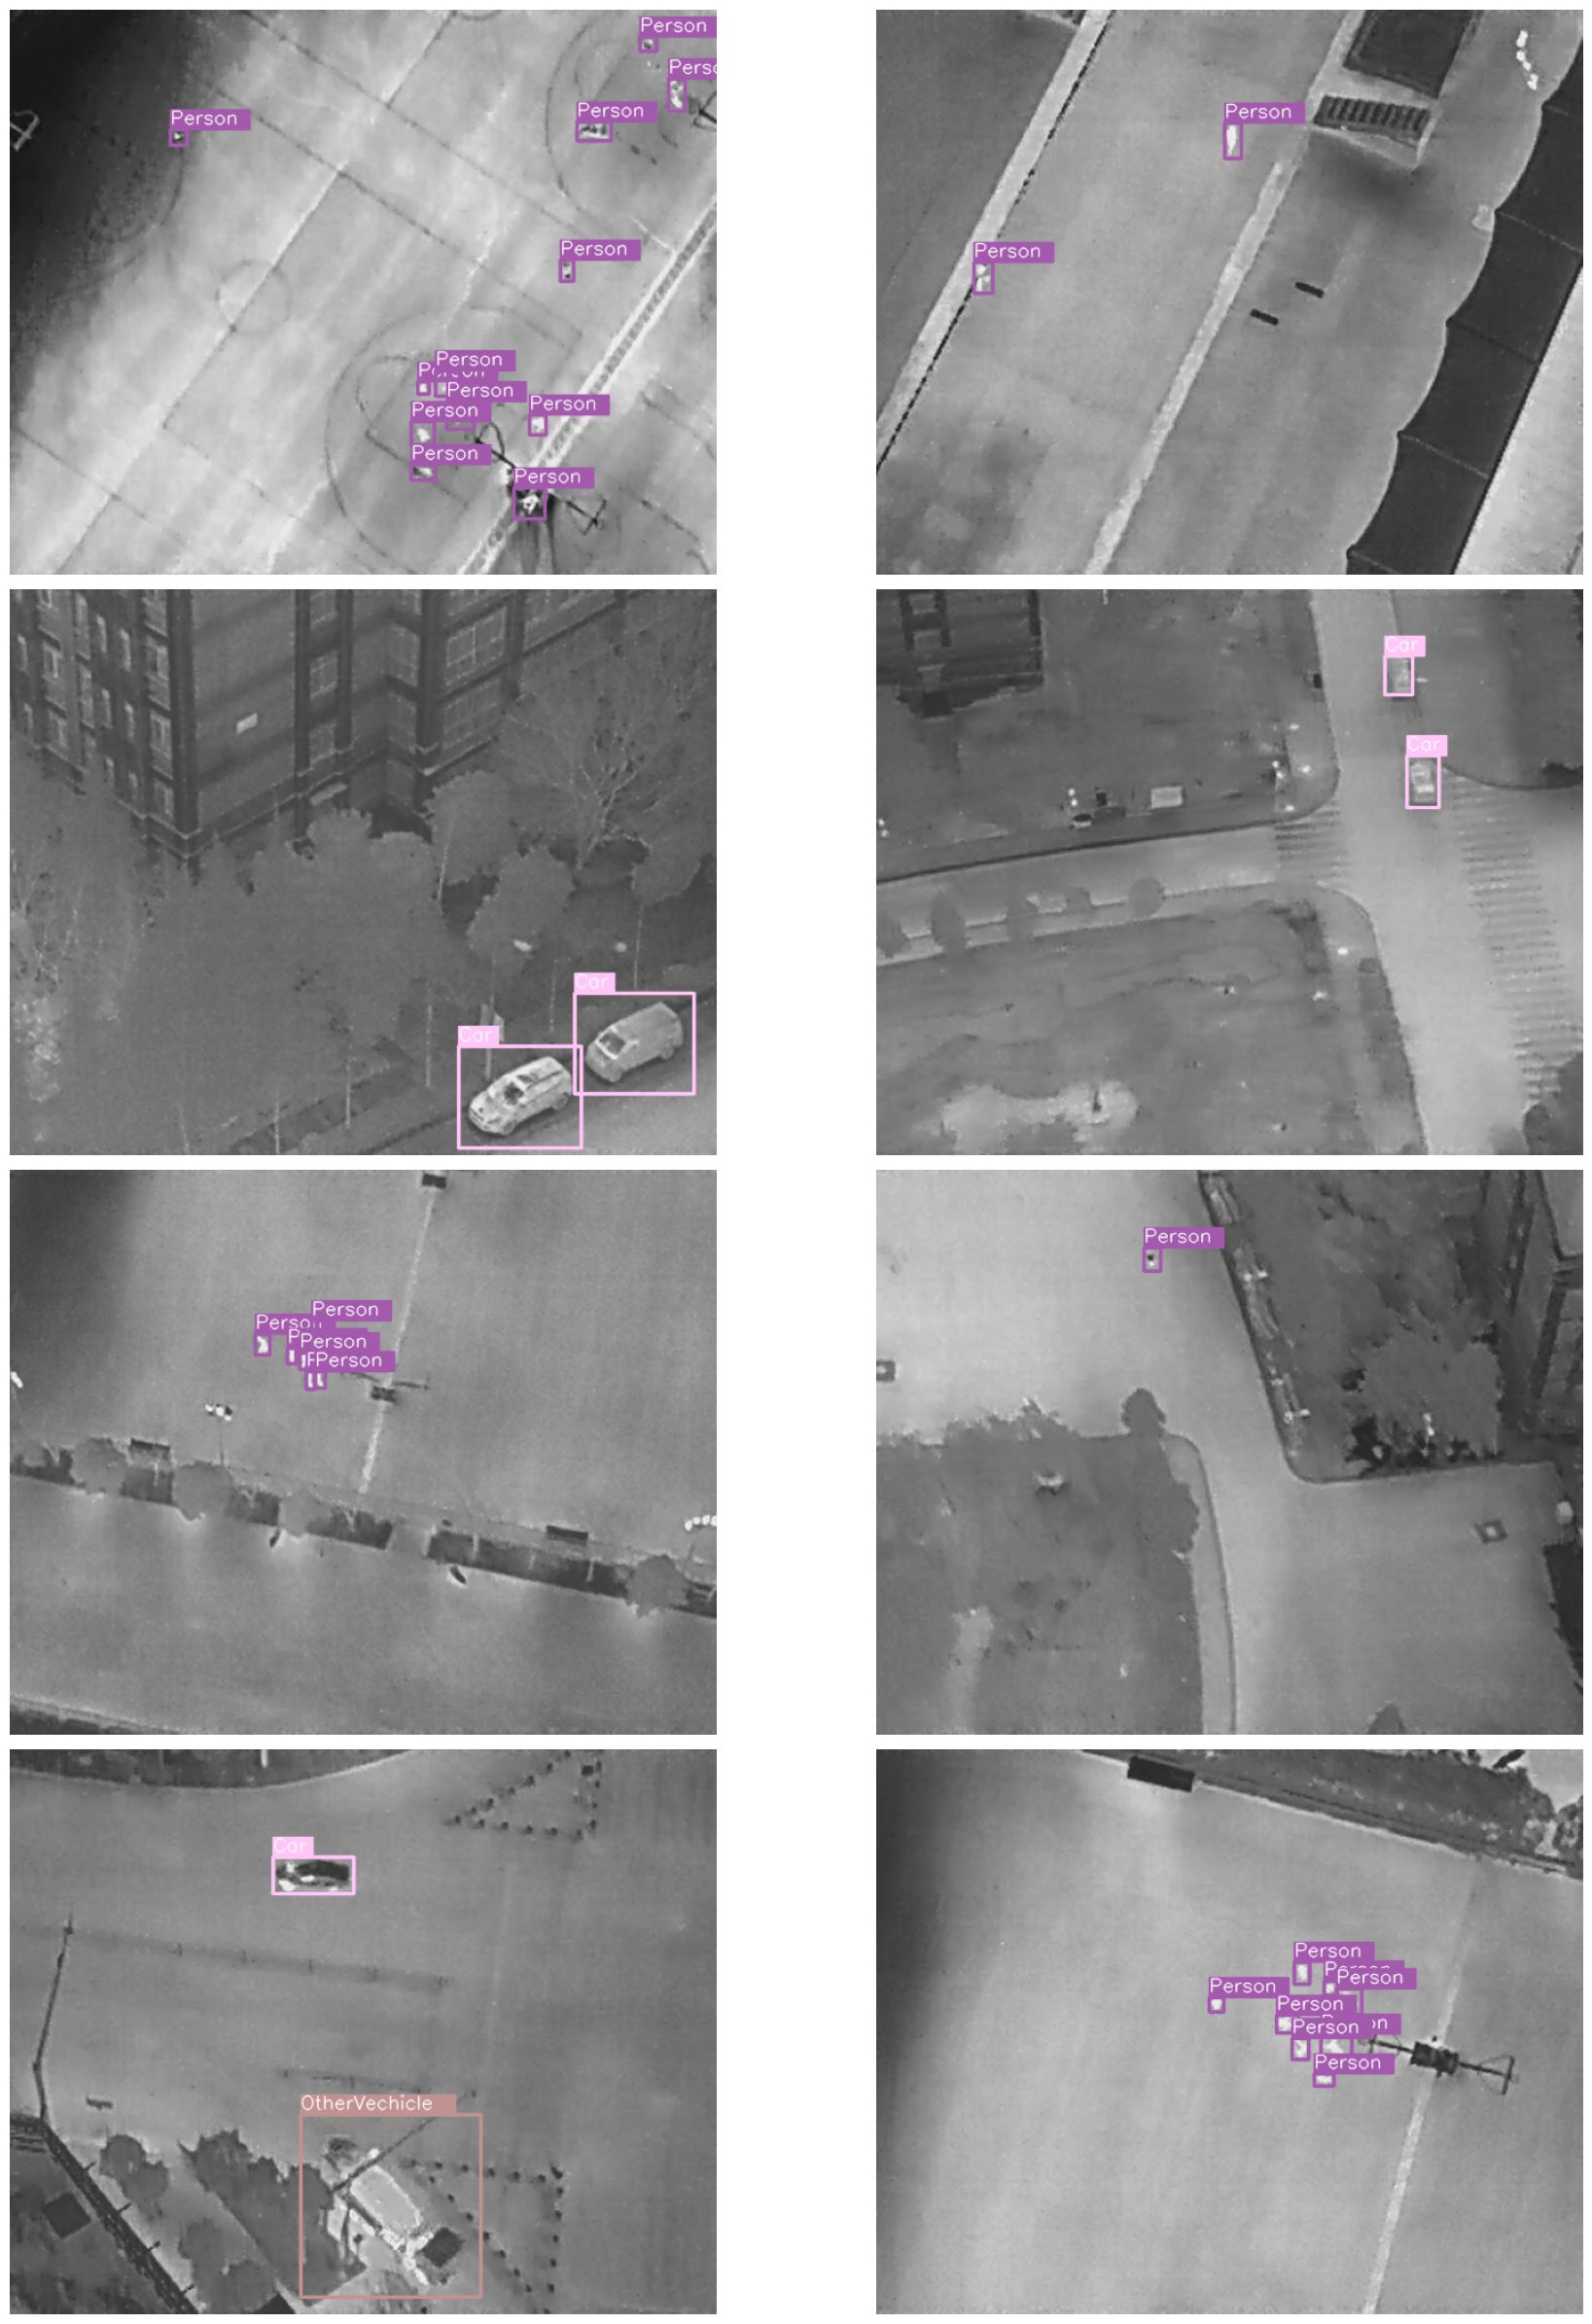

In [8]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [9]:
import yaml

# data.yaml oluşturma (Creating data.yaml)
data_dict = {
    "train": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/train",
    "val": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/val",
    "test": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test",
    "nc": 5,
    "names": ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare']
}

with open("dataset.yaml", "w") as f:
    yaml.dump(data_dict, f, sort_keys=False)


In [10]:
from ultralytics import YOLO

yolo_default_model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [11]:
yolo_default_train = yolo_default_model.train(data="/kaggle/working/dataset.yaml", epochs=50, batch = 16)

Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        287       2460       0.89       0.74      0.808      0.521
                Person        171       1168      0.903      0.829      0.907      0.496
                   Car        136        719      0.945      0.961      0.983      0.758
               Bicycle         53        554      0.888      0.816      0.908      0.536
          OtherVehicle          9         12      0.857      0.667      0.762      0.667
              DontCare          5          7      0.857      0.429      0.478      0.149
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


In [12]:
best_default_model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [13]:
from imutils import paths

log_dir = "/kaggle/working/runs/detect/train4"
for image_path in sorted(paths.list_images(log_dir)):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

In [14]:
!zip -r /kaggle/working/runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/train_batch0.jpg (deflated 4%)
  adding: runs/detect/train/BoxF1_curve.png (deflated 7%)
  adding: runs/detect/train/val_batch2_labels.jpg (deflated 7%)
  adding: runs/detect/train/args.yaml (deflated 53%)
  adding: runs/detect/train/labels.jpg (deflated 27%)
  adding: runs/detect/train/results.csv (deflated 62%)
  adding: runs/detect/train/train_batch5041.jpg (deflated 13%)
  adding: runs/detect/train/train_batch2.jpg (deflated 2%)
  adding: runs/detect/train/confusion_matrix.png (deflated 25%)
  adding: runs/detect/train/BoxR_curve.png (deflated 9%)
  adding: runs/detect/train/confusion_matrix_normalized.png (deflated 23%)
  adding: runs/detect/train/BoxPR_curve.png (deflated 11%)
  adding: runs/detect/train/val_batch2_pred.jpg (deflated 6%)
  adding: runs/detect/train/train_batch5042.jpg (deflated 10%)
  adding: runs/detect/train/weights/ (stored 0%)
  

In [15]:
!ls -lh /kaggle/working/


total 29M
-rw-r--r-- 1 root root  325 Nov 28 13:51 dataset.yaml
drwxr-xr-x 3 root root 4.0K Nov 28 13:51 runs
-rw-r--r-- 1 root root  18M Nov 28 14:12 runs.zip
-rw-r--r-- 1 root root 5.4M Nov 28 13:51 yolo11n.pt
-rw-r--r-- 1 root root 6.3M Nov 28 13:51 yolov8n.pt


# Inference on Test Images


In [17]:
results = best_default_model(os.path.join(ROOT_DIR, test_imgs_dir), conf=0.5, agnostic_nms=True, iou=0.5, save=True)


image 1/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_03307.jpg: 512x640 10 Cars, 36.7ms
image 2/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08074.jpg: 512x640 7 Cars, 2 OtherVehicles, 6.6ms
image 3/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08091.jpg: 512x640 10 Cars, 6.5ms
image 4/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08100.jpg: 512x640 3 Cars, 6.5ms
image 5/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03327.jpg: 512x640 3 Persons, 6.4ms
image 6/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03332.jpg: 512x640 3 Persons, 6.2ms
image 7/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03342.jpg: 512x640 5 Persons, 6.4ms
image 8/571

In [18]:
import random
import matplotlib.pyplot as plt

def show_random_result(results):
    random_result = random.choice(results)   
    img = random_result.plot()               

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()




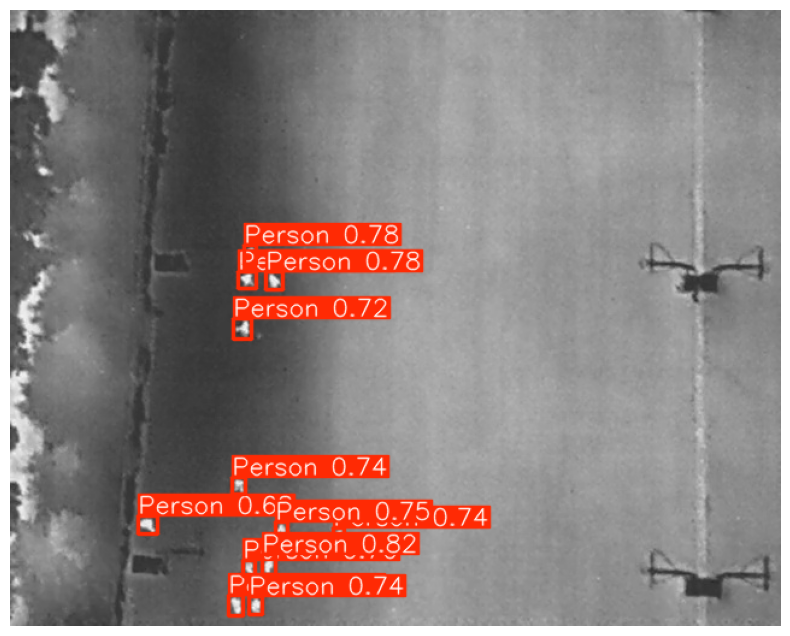

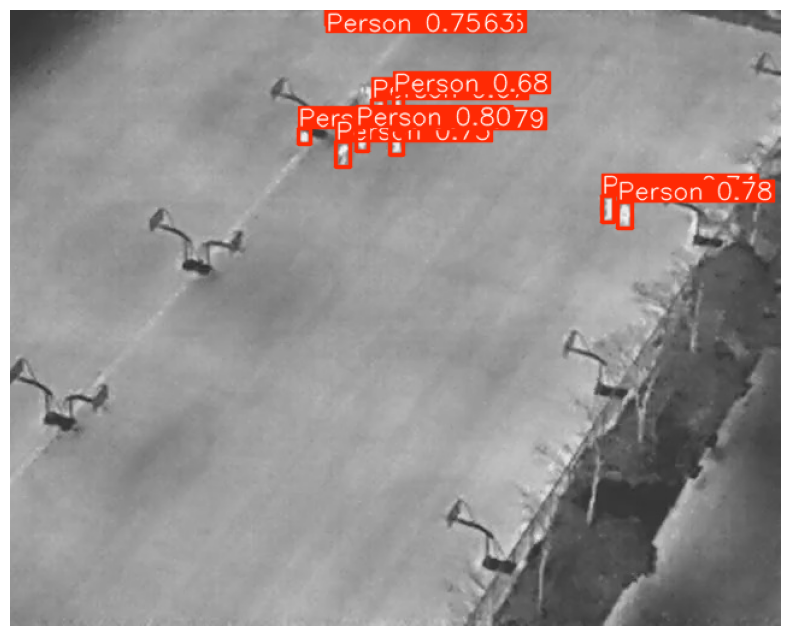

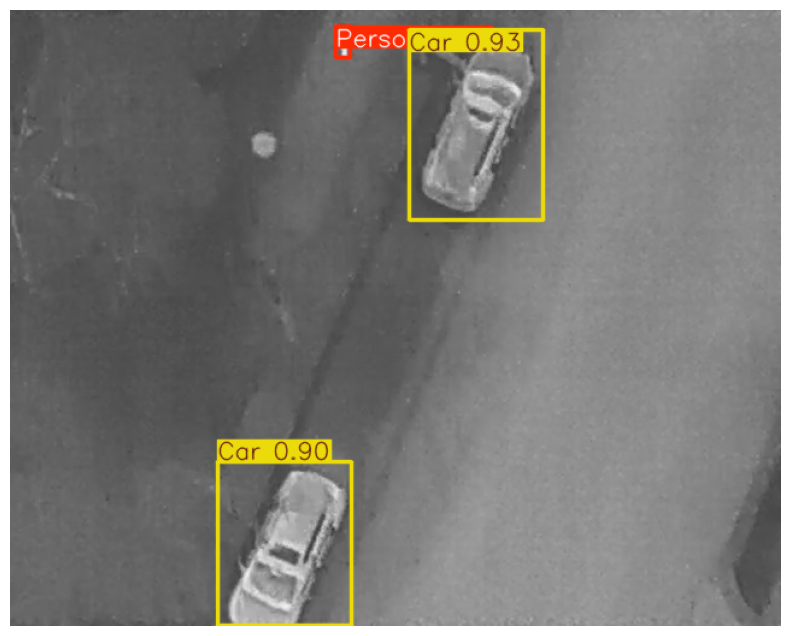

In [20]:
show_random_result(results)
show_random_result(results)
show_random_result(results)

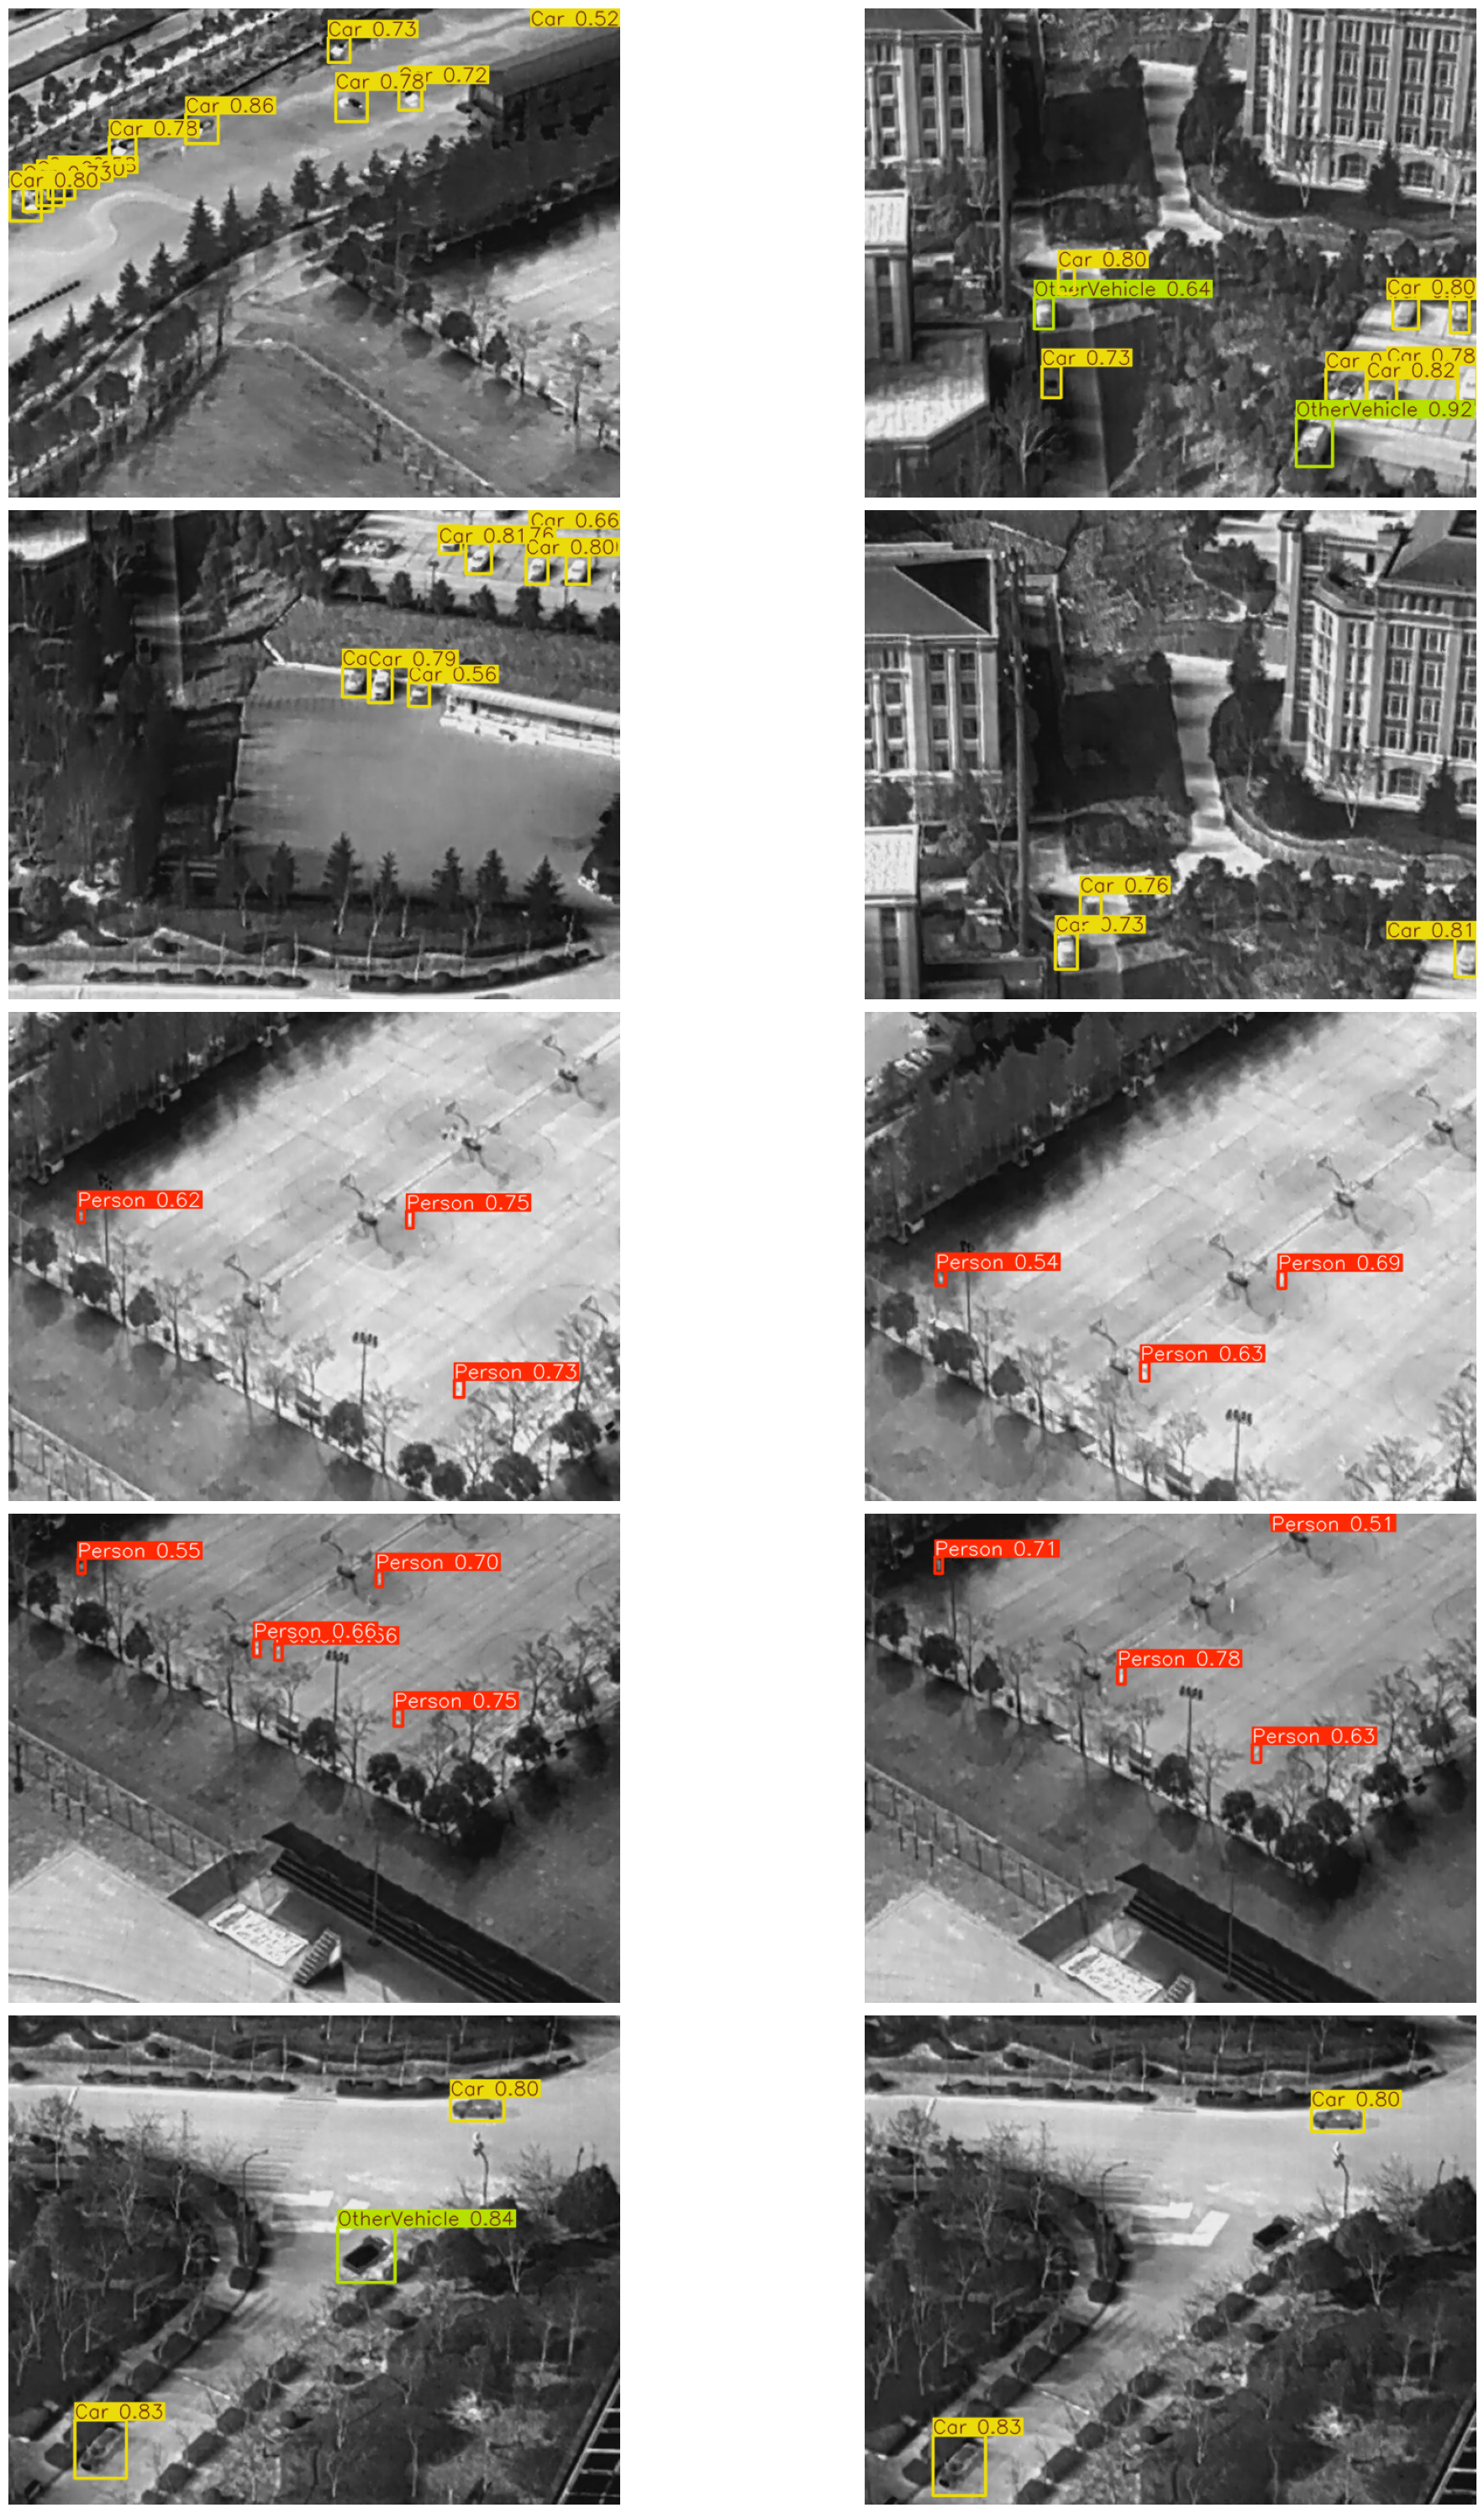

In [21]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))
    
for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Compare predictions with ground truth

In [23]:
ground_colors = [(255, 0, 0) for _ in range(len(classes))]

In [24]:
!ls runs/detect

predict  train


In [26]:
success = best_default_model.export(format="onnx")  # export the model to ONNX format
success

Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.11.13 environment at: /usr
Resolved 25 packages in 211ms
 Downloaded onnxruntime-gpu
Prepared 5 packages in 2.49s
Uninstalled 1 package in 6ms
Installed 5 packages in 13ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.77
 - protobuf==3.20.3
 + protobuf==6.33.1

requirements: AutoUpdate success ✅ 3.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.18.0 opset 19...
O

'/kaggle/working/runs/detect/train/weights/best.onnx'